# Homework 2

Young, James Yang

### Question 1

(a) In the linear factor model, $\alpha$ is the intercept for assets or the expected log-return when all factors are equal to zero, $\beta$ in this model is the factor loading matrix which shows the sensitivity of the assets, $f_t$ represents economic factors that can affect asset returns such as interest rates or unemployment, and $\epsilon_t$ is error or residual term which represents noise and/or random varation in the assets which cannot be explained by the factors.

(b)

In [1]:
# import packages
from scipy import optimize as opt
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd

In [2]:
# given log-returns of 10 popular stocks
yf.pdr_override()

stocks = ['TSLA', 'AMZN', 'EBAY', 'AAPL', 'MSFT', 'META', 'GOOGL',
          'NFLX', 'IBM', 'NVDA']
          
indices = ['^GSPC', 'BTC-USD']

prices = pdr.get_data_yahoo(stocks, start="2019-01-01", end="2022-12-31")[['Adj Close']]
factor = pdr.get_data_yahoo(indices, start="2019-01-01", end="2022-12-31")[['Adj Close']]

print(factor['Adj Close'].head())

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  2 of 2 completed
                BTC-USD        ^GSPC
Date                                
2019-01-01  3843.520020          NaN
2019-01-02  3943.409424  2510.030029
2019-01-03  3836.741211  2447.889893
2019-01-04  3857.717529  2531.939941
2019-01-05  3845.194580          NaN


In [3]:
# My answer

# interpolate data first to remove nan values
prices.interpolate()
factor.interpolate()

# make sure both factor and prices are matching dates, because bitcoin is traded on days that sp500 isn't
factor = factor.reindex(prices.index)

# compute the log-returns of the stocks and of the SP500 index as explicit factor
x = np.array(prices[['Adj Close']].apply(np.log).apply(np.diff).xs('Adj Close',axis=1)) #1007x10
f = np.array(factor[['Adj Close']].apply(np.log).apply(np.diff).xs('Adj Close',axis=1)) #1007x2
t,n = x.shape # t = days, n = stocks

# set up alpha and beta as cvxpy variables to solve
alpha = cp.Variable(n)
beta = cp.Variable((n,2))

beta_star = np.zeros((10,2))
alpha_star = np.zeros(10)

obj = 0
# solve alpha and beta

for i in range(t):
    obj += cp.sum_squares(x[i] - alpha - beta@f[i].T)


problem_b = cp.Problem(cp.Minimize(obj)).solve()

alpha_min = alpha.value
beta_min = beta.value

# print("beta values: \n", beta_min)
# print("\n \n alpha values: \n", alpha_min)
pd.DataFrame(np.column_stack([alpha_min,beta_min]).real, index=stocks, columns=["alpha","b1","b2"])

/home/jamesyoung/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


,alpha,b1,b2
TSLA,0.000709,-0.006548,1.228193
AMZN,-0.000376,0.030284,0.993262
EBAY,0.000082,-0.009761,0.830940
AAPL,0.000038,0.003613,1.109195
MSFT,0.000115,-0.028000,0.860260
META,-0.000666,0.018550,1.233919
GOOGL,0.000395,0.007276,1.171780
NFLX,-0.000379,0.044232,0.975753
IBM,0.000693,0.043370,1.655125
NVDA,0.001051,0.106543,1.347903


(c)

 X = $x^T$, F = [3, factor], gamma = [alpha beta] where gamma is N×3

In [4]:
# For F, make factor a 3*1007 array
F = np.column_stack([np.ones(len(f)), f]).T
# For X, x = x transpose
X = x.T

# gamma is n*3, [alpha beta]
gamma = cp.Variable((n,3))
# define and solve for gamma
cp.Problem(cp.Minimize(cp.sum_squares(X - gamma@F))).solve()

# print alpha and beta from gamma with cvxpy
# print("beta values: \n", gamma.value.T[1:].T)
# print("\n \n alpha values: \n", gamma.value.T[0])
pd.DataFrame(np.column_stack([gamma.value.T[0],gamma.value.T[1:].T]).real, index=stocks, columns=["alpha","b1","b2"])

,alpha,b1,b2
TSLA,0.000709,-0.006548,1.228193
AMZN,-0.000376,0.030284,0.993262
EBAY,0.000082,-0.009761,0.830940
AAPL,0.000038,0.003613,1.109195
MSFT,0.000115,-0.028000,0.860260
META,-0.000666,0.018550,1.233919
GOOGL,0.000395,0.007276,1.171780
NFLX,-0.000379,0.044232,0.975753
IBM,0.000693,0.043370,1.655125
NVDA,0.001051,0.106543,1.347903


(d) 

Closed form solution (from python lecture slides): $\boldsymbol{\Gamma} = \mathbf{X}^T {\mathbf{F}}
({\mathbf{F}}^T {\mathbf{F}})^{-1}$

In [5]:
# solve with closed form solution, from lecture slides 
Gamma_mat = np.linalg.solve(F @ F.T, F @ X.T)

# take alpha and beta values
alpha_sol = Gamma_mat[0]
beta_sol = Gamma_mat[1:]

# print values
# print("beta values: \n", beta_sol)
# print("\n \n alpha values: \n", alpha_sol)
pd.DataFrame(np.column_stack([alpha_sol,beta_sol.T]).real, index=stocks, columns=["alpha","b1","b2"])

,alpha,b1,b2
TSLA,0.000709,-0.006548,1.228193
AMZN,-0.000376,0.030284,0.993262
EBAY,0.000082,-0.009761,0.830940
AAPL,0.000038,0.003613,1.109195
MSFT,0.000115,-0.028000,0.860260
META,-0.000666,0.018550,1.233919
GOOGL,0.000395,0.007276,1.171780
NFLX,-0.000379,0.044232,0.975753
IBM,0.000693,0.043370,1.655125
NVDA,0.001051,0.106543,1.347903


The results from part (d) are extremely close to part (b) and part(c). 

(e)

Text(0.5, 0, 'alpha')

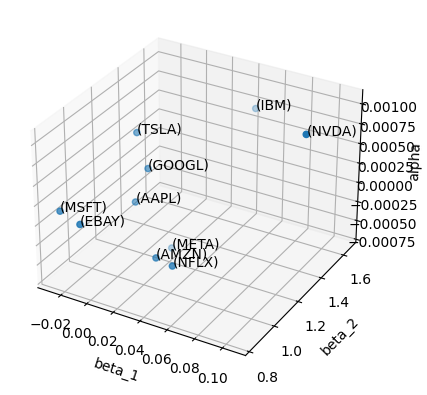

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# scatter plot (b1, b2, a)
ax.scatter(beta_sol[0], beta_sol[1], alpha_sol)

# label plots
for x,y,z,stock in zip(beta_sol[0], beta_sol[1], alpha_sol, stocks):
    label = '(%s)' % ( stock)
    ax.text(x, y, z, label)

ax.set_xlabel('beta_1')
ax.set_ylabel('beta_2')
ax.set_zlabel('alpha')



(f) Based on the previous plot, Amazon, Netflix, and Meta are less risky to invest in as they are closer to the origin. This is because we want to minimize beta and alpha as much as possible since a higher beta value means more volatility and a higher alpha value means more unpredictability from returns not influenced by factors.

(g)

In [7]:
# from py session slide
from sklearn.preprocessing import scale

X = prices[['Adj Close']].apply(np.log).apply(np.diff).xs('Adj Close',axis=1)

# psa
K = 2
alpha = np.mean(X, axis=0)
X_ = scale(X, with_std=False)
Sigma_prev = np.zeros((n, n))
Psi = np.zeros((n, n))
Sigma = X_.T @ X_ / (t-1)

# repeat estimates and eigen-decomposition until convergence
while (np.linalg.norm(Sigma - Sigma_prev)/np.linalg.norm(Sigma) > 1e-3):
  values, vectors = np.linalg.eig(Sigma - Psi)
  B = vectors[:, :K] * np.sqrt(values[:K]) #beta = gamma*lambda^0.5
  Psi = np.diag(np.diag(Sigma - B @ B.T))
  Sigma_prev = Sigma
  Sigma = B @ B.T + Psi
  gamma = vectors[:, :K]
  lbda  = values[:K]


In [8]:
# estimated alpha and beta values
pd.DataFrame(np.column_stack([alpha,B]).real, index=stocks, columns=["alpha","b1","b2"])

,alpha,b1,b2
TSLA,0.001218,4.906069e-10,0.017702
AMZN,0.000087,-4.085346e-11,0.017889
EBAY,0.000419,-2.821623e-11,0.012355
AAPL,0.000511,-3.681725e-11,0.016121
MSFT,0.000439,-1.702112e-11,0.007453
META,-0.000119,-4.797417e-11,0.021006
GOOGL,0.000900,-3.825716e-11,0.016752
NFLX,0.000096,-4.910719e-11,0.021503
IBM,0.001454,-6.454138e-11,0.028261
NVDA,0.001772,-7.335629e-11,0.032121


In [9]:
# compare to part b
pd.DataFrame(np.column_stack([alpha_min,beta_min]).real, index=stocks, columns=["alpha","b1","b2"])

,alpha,b1,b2
TSLA,0.000709,-0.006548,1.228193
AMZN,-0.000376,0.030284,0.993262
EBAY,0.000082,-0.009761,0.830940
AAPL,0.000038,0.003613,1.109195
MSFT,0.000115,-0.028000,0.860260
META,-0.000666,0.018550,1.233919
GOOGL,0.000395,0.007276,1.171780
NFLX,-0.000379,0.044232,0.975753
IBM,0.000693,0.043370,1.655125
NVDA,0.001051,0.106543,1.347903


In [10]:
# get f estimated
f_hat = np.zeros((t,2))
# fhat = lambda^-0.5 * gamma^T * (x-alpha) pg 50 lecture
for i in range(t):
  x_alpha = np.array((X.iloc[i]-alpha))
  x_alpha = x_alpha.reshape(10,-1)
  f_hat[i] = ((np.power(lbda,-0.5)*gamma).T @ x_alpha).T

# print estimated 
alpha_beta_estimated = pd.DataFrame(np.column_stack([alpha, B]).real, index=stocks, columns=["a","b1","b2"])
f_estimated = pd.DataFrame(np.column_stack(f_hat.T).real)
f_estimated

/tmp/ipykernel_108600/1092792615.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  f_hat[i] = ((np.power(lbda,-0.5)*gamma).T @ x_alpha).T


,0,1
0,-1.545314e+08,-1.713280
1,-5.942139e+06,2.457397
2,-5.160916e+07,1.235647
3,2.379384e+07,0.338511
4,1.770330e+07,0.391809
...,...,...
1002,-4.826102e+06,-0.093349
1003,4.187113e+07,-2.018776
1004,-5.300016e+07,-0.360514
1005,-1.486118e+07,1.920909


In [11]:
# compare to part b
pd.DataFrame(f,columns=indices)

,^GSPC,BTC-USD
0,-0.027422,-0.025068
1,0.005452,0.033759
2,0.042511,0.006986
3,0.001390,0.009649
4,0.001103,0.004090
...,...,...
1002,-0.001986,0.005851
1003,-0.004761,-0.004058
1004,-0.009895,-0.012093
1005,0.005409,0.017311


I think the macroeconomic factor model used in part (b) works better in this case rather than estimating factors through PCA since estimating factors can introduce additional sources of uncertainty and potential biases depending on the dataset. However, for situations where factors are difficult to obtain or if there are uncertainty about the factors, it  may be better then to use the statistical factor model instead. Since in this case we are using a small amount of factors that are well-established, part b method works better.

### Question 2

(a)

In [12]:
# get 'AAPL’, ‘MSFT’ and ‘GOOGL' from dataset
new_stocks = ['AAPL', 'MSFT', 'GOOGL']
new_dataset = pdr.get_data_yahoo(new_stocks, start="2019-01-01", end="2022-12-31")[['Adj Close']]

new_dataset.interpolate()

# divide into training and test data
train_data = new_dataset.loc["2019-01-01":"2021-12-31"]
test_data = new_dataset.loc["2022-01-01":"2022-12-31"]

log_return = np.array(new_dataset[['Adj Close']].apply(np.log).apply(np.diff).xs('Adj Close',axis=1))
train_log_return = np.array(train_data[['Adj Close']].apply(np.log).apply(np.diff).xs('Adj Close',axis=1))
test_log_return = np.array(test_data[['Adj Close']].apply(np.log).apply(np.diff).xs('Adj Close',axis=1))

[*********************100%***********************]  3 of 3 completed


In [13]:
# get data mean and cov
mu_data = np.mean(log_return, axis=0)
sigma_data = np.cov(log_return.T)
mu_data2d = np.array([mu_data]).T # to 2d array

# from hw 1 problem 1, get w
w_var = cp.Variable(len(new_stocks)) 
portfolio_ret = mu_data2d.T @ w_var
objective = cp.QuadForm(w_var, sigma_data)
beta = 0.001 # beta = 0.05 didn't work, use suggestion from email
prob = cp.Problem(cp.Minimize(objective),
                    [portfolio_ret >= beta,
                    w_var >= 0,
                    cp.sum(w_var) == 1])
prob.solve()

w = w_var.value
w

array([0.43974859, 0.10277962, 0.45747179])

In [14]:
# get training mean and cov
mu_data = np.mean(train_log_return, axis=0)
sigma_data = np.cov(train_log_return.T)
mu_data2d = np.array([mu_data]).T # to 2d array

# use equation s = (w.T * mu) / sqrt(w.T * sigma * w)
def sharpe_ratio(p1,p2):
    sig = p1*sigma_data + (1-p1)*np.diag(np.diag(sigma_data))
    u = p2*mu_data + (1-p2)*(np.mean(mu_data))*np.ones(3).T
    s = (w.T@u)/np.sqrt(w.T@sig@w)
    return s

(b)

In [15]:
# computing sr values

# rho values
rho = [0,0.2,0.4,0.6,0.8,1]
rho_num = len(rho)
ratio_values = np.zeros((rho_num,rho_num))

# get sharpe ratio for each p1 and p2 values 
for i in range(rho_num):
    for j in range(rho_num):
        ratio_values[i,j] = sharpe_ratio(rho[i],rho[j])


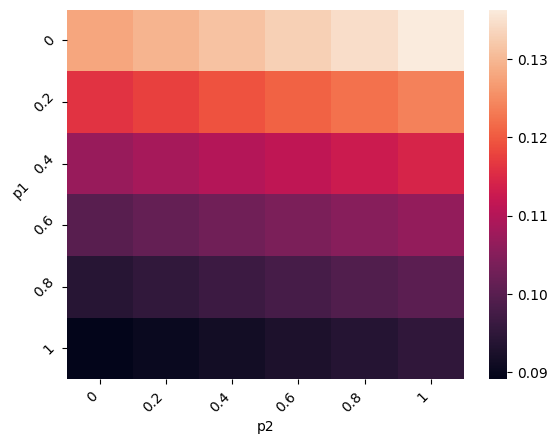

In [16]:
import seaborn as sns

# label values
data_label = ['0','0.2','0.4','0.6','0.8','1']

# plot heatmap
ax = sns.heatmap(
    ratio_values
)

# set axis labels
ax.set_xlabel("p2")
ax.set_ylabel("p1", rotation=45)
ax.set_xticklabels(
    data_label,
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(
    data_label,
    rotation=45,
    horizontalalignment='right'
)

plt.show()

Based on the heatmap, the largest Sharpe ratio has the pair $(\rho _1, \rho _2)$ = (0,1).

(c)

In [17]:
# get test mean and cov
mu_data = np.mean(test_log_return, axis=0)
sigma_data = np.cov(test_log_return.T)
mu_data2d = np.array([mu_data]).T # to 2d array

print("Sharpe ratio for test data is: ",sharpe_ratio(0,1))

Sharpe ratio for test data is:  -0.09578150553547947


(d)

In [18]:
# no shrinkage estimator
print("Sharpe ratio for no shrinkage estimator is: ", sharpe_ratio(1,1))

Sharpe ratio for no shrinkage estimator is:  -0.06459155996215156
